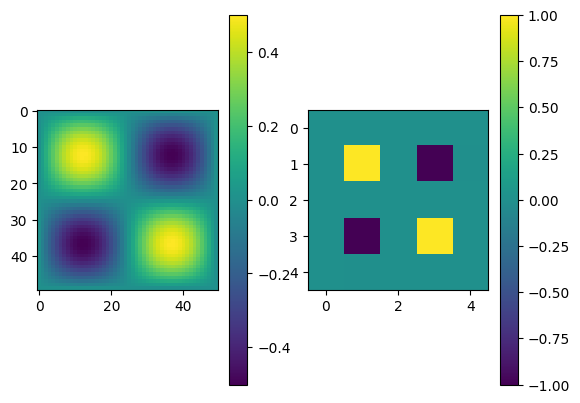

In [24]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt

# Define parameters
Lx, Ly = 1.0, 1.0   # Domain size in x and y directions
Nx, Ny = 50, 50     # Number of grid points in x and y directions
hx, hy = Lx / (Nx - 1), Ly / (Ny - 1)   # Grid spacing in x and y directions
h2_inv = 1 / (6 * hx**2)   # Factor for the 9-point stencil Laplacian

# Create grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

# Define the source term f(x, y)
def f(x, y):
#     return np.sin(np.pi * x) * np.sin(np.pi * y)
    return -4*np.pi**2 * uexact(x,y)

# Initialize the source term array
F = f(X, Y).flatten()

# Boundary conditions (u=0 on boundary)
bc_val = 0.0

# Sparse matrix setup for the 9-point stencil
N = Nx * Ny  # Total number of unknowns
A = sp.lil_matrix((N, N))  # Create sparse matrix in LIL format for easy indexing

# Fill in matrix A using the 9-point stencil
for i in range(Nx):
    for j in range(Ny):
        index = i * Ny + j
        if i == 0 or i == Nx-1 or j == 0 or j == Ny-1:
            # Apply Dirichlet boundary conditions
            A[index, index] = 1
            F[index] = bc_val
        else:
            # Interior points: apply the 9-point stencil
            A[index, index] = -20 
            A[index, index + 1] = 4   # Right
            A[index, index - 1] = 4   # Left
            A[index, index + Ny] = 4   # Up
            A[index, index - Ny] = 4 # Down
            A[index, index + Ny + 1] = 1  # Top-right
            A[index, index + Ny - 1] = 1  # Top-left
            A[index, index - Ny + 1] = 1 # Bottom-right
            A[index, index - Ny - 1] =1  # Bottom-left

dof = [6,7,8,11,12,13,16,17,18]
            
# print(A.todense()[dof,:][:,dof])
# Convert A to CSR format for efficient solving
A = A.tocsr()

# Solve the linear system
u = spla.spsolve(A, (1.0/h2_inv)*F)

# Reshape solution to a 2D grid
u = u.reshape((Nx, Ny))


fig, ax = plt.subplots(ncols=2)
pos = ax[0].imshow(u); fig.colorbar(pos, ax=ax[0])
pos = ax[1].imshow(usol); fig.colorbar(pos, ax=ax[1])
plt.show()
# # Plot the solution
# plt.figure(figsize=(8, 6))
# plt.contourf(X, Y, u, 20, cmap="viridis")
# plt.colorbar(label="u(x, y)")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Solution of the 2D Laplace Equation with 9-Point Stencil (Direct Solver)")
# plt.show()


[[-20.   4.   1.   4.   1.   0.   0.   0.   0.]
 [  4. -20.   4.   1.   4.   1.   0.   0.   0.]
 [  1.   4. -20.   4.   1.   4.   1.   0.   0.]
 [  4.   1.   4. -20.   4.   1.   4.   1.   0.]
 [  1.   4.   1.   4. -20.   4.   1.   4.   1.]
 [  0.   1.   4.   1.   4. -20.   4.   1.   4.]
 [  0.   0.   1.   4.   1.   4. -20.   4.   1.]
 [  0.   0.   0.   1.   4.   1.   4. -20.   4.]
 [  0.   0.   0.   0.   1.   4.   1.   4. -20.]]


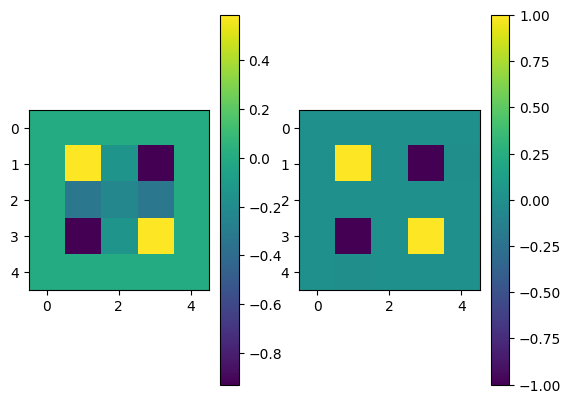

[0.8155053859415041]


In [14]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import numpy as np

uexact = lambda x,y: np.sin(2*np.pi*x)*np.sin(2*np.pi*y)
f = lambda x,y: -4*np.pi**2 * uexact(x,y)

errors = []
Ns = [4]#[2**n for n in range(3, 6)]
for N in Ns:
    h = 1/N
    x = np.linspace(0, 1, N+1) 
    y = np.linspace(0, 1, N+1)

    M = (N-1)*(N-1)
    ones = np.ones(M)
    A2D = diags([4*ones, -20*ones, 4*ones], offsets=[-1,0,1], shape=(M,M), format='csc')\
        + diags([ones, 4*ones, ones], offsets=[-N, -(N-1), -(N-2)], shape=(M,M), format='csc')\
        + diags([ones, 4*ones, ones], offsets=[N-2, N-1, N], shape=(M,M), format='csc')
    print(A2D.todense())
    Xplot = np.zeros((N+1 , N+1))
    Yplot = np.zeros((N+1 , N+1))
    usol = np.zeros((N+1, N+1))
    b = np.zeros((N+1, N+1))
    
    Dirichletnode =[]
    k=0
    for j in range(N+1):
        for i in range(N+1):
            Xplot[i,j] = x[i]
            Yplot[i,j] = y[j]
            usol[i,j] = uexact(x[i], y[j])
            
            if 0 < i < N and 0 < j < N:
                b[i,j] = f(x[i], y[j])
            else:
                Dirichletnode.append(k)
            k += 1
    
    b = b.reshape((N+1)*(N+1))
    Intnodes= np.setdiff1d(range((N+1)*(N+1)), Dirichletnode)
    uh = np.zeros((N+1)*(N+1))
    uh[Intnodes] = spsolve(A2D, 6*h**2 * b[Intnodes])
    uh = uh.reshape((N+1,N+1))

    fig, ax = plt.subplots(ncols=2)
    pos = ax[0].imshow(uh); fig.colorbar(pos, ax=ax[0])
    pos = ax[1].imshow(usol); fig.colorbar(pos, ax=ax[1])
    plt.show()

    errors.append(np.linalg.norm(uh-usol))

print(errors)